# Multi-step forecasts

Two modeling strategies for multi-step forecasting

- Recursively forecasting the future n periods with one model
- Directly forecasting each of the future n periods with n models

## Installation
- sktime
- lightgbm

In [2]:
#!pip install sktime
#!pip install lightgbm

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# IF you use Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive')

# path = '/content/gdrive/My Drive/data/time_series'
# data = pd.read_csv(path + '/electric_consumption.csv', index_col='Date')
# data.index = pd.to_datetime(data.index)
# data = data.sort_index() # Make sure the data are sorted
# data.index = pd.PeriodIndex(data.index, freq='H') # Make sure the Index is sktime format
# data.index

In [3]:
path = '/Users/chriskuo/Downloads/data'
data = pd.read_csv(path + '/electric_consumption.csv', index_col='Date')
data.index = pd.to_datetime(data.index)
data = data.sort_index() # Make sure the data are sorted
data.index = pd.PeriodIndex(data.index, freq='H') # Make sure the Index is sktime format
data.index

/var/folders/b8/hq7p21n142n321y966q8j1600000gn/T/ipykernel_3217/2030720080.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.index = pd.to_datetime(data.index)
/var/folders/b8/hq7p21n142n321y966q8j1600000gn/T/ipykernel_3217/2030720080.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data.index = pd.PeriodIndex(data.index, freq='H') # Make sure the Index is sktime format


PeriodIndex(['2017-12-11 00:00', '2017-12-11 01:00', '2017-12-11 02:00',
             '2017-12-11 03:00', '2017-12-11 04:00', '2017-12-11 05:00',
             '2017-12-11 06:00', '2017-12-11 07:00', '2017-12-11 08:00',
             '2017-12-11 09:00',
             ...
             '2020-06-25 08:00', '2020-06-25 09:00', '2020-06-25 10:00',
             '2020-06-25 11:00', '2020-06-25 12:00', '2020-06-25 13:00',
             '2020-06-25 14:00', '2020-06-25 15:00', '2020-06-25 16:00',
             '2020-06-25 17:00'],
            dtype='period[h]', name='Date', length=22201)

In [4]:
y = data['Consumption']
y

Date
2017-12-11 00:00     56
2017-12-11 01:00     56
2017-12-11 02:00     55
2017-12-11 03:00     52
2017-12-11 04:00     46
                   ... 
2020-06-25 13:00     73
2020-06-25 14:00     82
2020-06-25 15:00     74
2020-06-25 16:00     99
2020-06-25 17:00    103
Freq: h, Name: Consumption, Length: 22201, dtype: int64

In [5]:
cuttime = int(len(y)*0.9) # Take 90% for training
train = y[0:cuttime]
test = y[cuttime::]
test

Date
2020-03-25 05:00     52
2020-03-25 06:00     47
2020-03-25 07:00     44
2020-03-25 08:00     42
2020-03-25 09:00     41
                   ... 
2020-06-25 13:00     73
2020-06-25 14:00     82
2020-06-25 15:00     74
2020-06-25 16:00     99
2020-06-25 17:00    103
Freq: h, Name: Consumption, Length: 2221, dtype: int64

## (1) Recursively forecasting the future n periods with one model: sktime

### GBM

In [8]:
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import GradientBoostingRegressor
gbm_regressor = GradientBoostingRegressor()
gbm_forecaster = make_reduction(gbm_regressor, window_length=30, strategy="recursive")
gbm_forecaster.fit(train)

RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor(),
                                     window_length=30)

In [9]:
len(list(range(1, len(test)+1,1)))

2221

In [10]:
vlen = 600
y_test_pred = gbm_forecaster.predict(fh=list(range(1, vlen,1)))
y_test_pred

2020-03-25 05:00    52.290698
2020-03-25 06:00    46.840137
2020-03-25 07:00    43.287588
2020-03-25 08:00    40.912258
2020-03-25 09:00    40.361486
                      ...    
2020-04-18 23:00    85.009296
2020-04-19 00:00    83.091387
2020-04-19 01:00    79.518339
2020-04-19 02:00    74.506086
2020-04-19 03:00    67.886682
Freq: h, Name: Consumption, Length: 599, dtype: float64

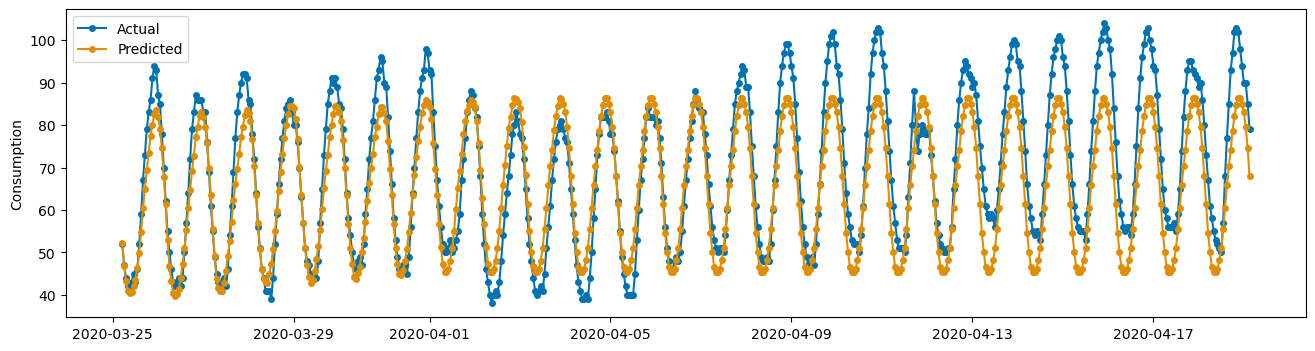

In [12]:
from sktime.utils.plotting import plot_series
actual = test[test.index<=y_test_pred.index.max()]
plot_series(actual, y_test_pred, labels=['Actual', 'Predicted'])
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(actual, y_test_pred)

0.09339982449579289

### LightGBM

In [14]:
import lightgbm as lgb
lgb_regressor = lgb.LGBMRegressor(num_leaves = 10,
              learning_rate = 0.02,
              feature_fraction = 0.8,
              max_depth = 5,
              verbose = 0,
              num_boost_round = 15000,
              nthread = -1
)
lgb_regressor = lgb.LGBMRegressor() # Use the default setting
lgb_forecaster = make_reduction(lgb_regressor, window_length=30, strategy="recursive")
lgb_forecaster.fit(train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 19950, number of used features: 30
[LightGBM] [Info] Start training from score 64.347569


RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(),
                                     window_length=30)

In [15]:
vlen = 100
y_test_pred = lgb_forecaster.predict(fh=list(range(1, vlen,1)))
y_test_pred

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but L

2020-03-25 05:00    53.610659
2020-03-25 06:00    49.015347
2020-03-25 07:00    44.441275
2020-03-25 08:00    42.115795
2020-03-25 09:00    41.055700
                      ...    
2020-03-29 03:00    67.019380
2020-03-29 04:00    59.760147
2020-03-29 05:00    53.646192
2020-03-29 06:00    49.010932
2020-03-29 07:00    44.583853
Freq: h, Name: Consumption, Length: 99, dtype: float64

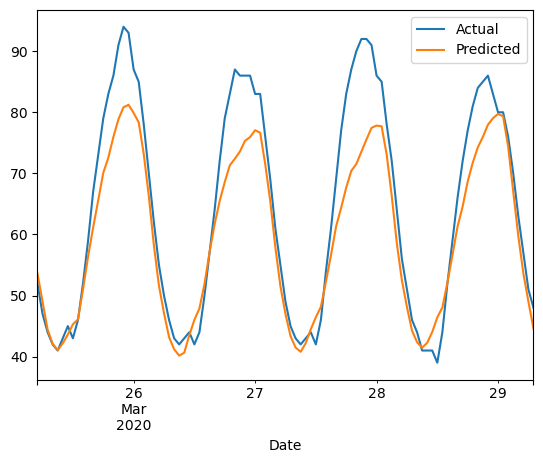

In [16]:
actual = test[test.index<=y_test_pred.index.max()]
actual.plot(label='Actual')
y_test_pred.plot(label='Predicted')
import matplotlib.pyplot as plt
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(actual, y_test_pred)

0.07405010507213998

### Evaluation metric: Mean absolute percentage error (MAPE) vs. symmetric MAPE

- The default is symmetric = False
- The best value is 0.0. Both MAPE and sMAPE output is non-negative floating point.
- sMAPE is measured in absolute percentage error relative to the actual values in the test data. Because it takes the absolute value rather than square the percentage forecast error, it penalizes large errors less than MSPE, RMSPE, MdSPE or RMdSPE.

In [18]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(actual, y_test_pred, symmetric=False))

0.0740501050721400


In [19]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(actual, y_test_pred, symmetric=True))

0.0774254342929647


In [20]:
from sktime.utils.plotting import plot_series
plot_series(actual, y_test_pred, labels=["Actual", "Prediction"], x_label='Date', y_label='Consumption');

## (2) Directly forecasting each of the future n periods with n models

In [31]:
from sktime.forecasting.compose import make_reduction
import lightgbm as lgb
lgb_regressor = lgb.LGBMRegressor(num_leaves = 10,
              learning_rate = 0.02,
              feature_fraction = 0.8,
              max_depth = 5,
              verbose = 0,
              num_boost_round = 15000,
              nthread = -1
)

lgb_regressor = lgb.LGBMRegressor() # Use the default setting
lgb_forecaster = make_reduction(lgb_regressor, window_length=30, strategy="direct")

In [32]:
vlen = 100
fh=list(range(1, vlen,1))
lgb_forecaster.fit(train, fh = fh)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 19852, number of used features: 30
[LightGBM] [Info] Start training from score 64.351098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 19852, number of used features: 30
[LightGBM] [Info] Start training from score 64.352760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train s

DirectTabularRegressionForecaster(estimator=LGBMRegressor(), window_length=30)

In [33]:
y_test_pred = lgb_forecaster.predict(fh=fh)
y_test_pred

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but L

Date
2020-03-25 05:00    53.508253
2020-03-25 06:00    47.855487
2020-03-25 07:00    43.299835
2020-03-25 08:00    41.274854
2020-03-25 09:00    40.688516
                      ...    
2020-03-29 03:00    67.842783
2020-03-29 04:00    58.069962
2020-03-29 05:00    50.839247
2020-03-29 06:00    46.161004
2020-03-29 07:00    44.269871
Freq: h, Name: Consumption, Length: 99, dtype: float64

In [34]:
from sktime.utils.plotting import plot_series
plot_series(actual, y_test_pred, labels=["Actual", "Prediction"], x_label='Date', y_label='Consumption');

In [35]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(actual, y_test_pred, symmetric=False))

0.0709950620572392


In [36]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(actual, y_test_pred, symmetric=True))

0.0744151961030635


### ARIMA

In [37]:
!pip install pmdarima

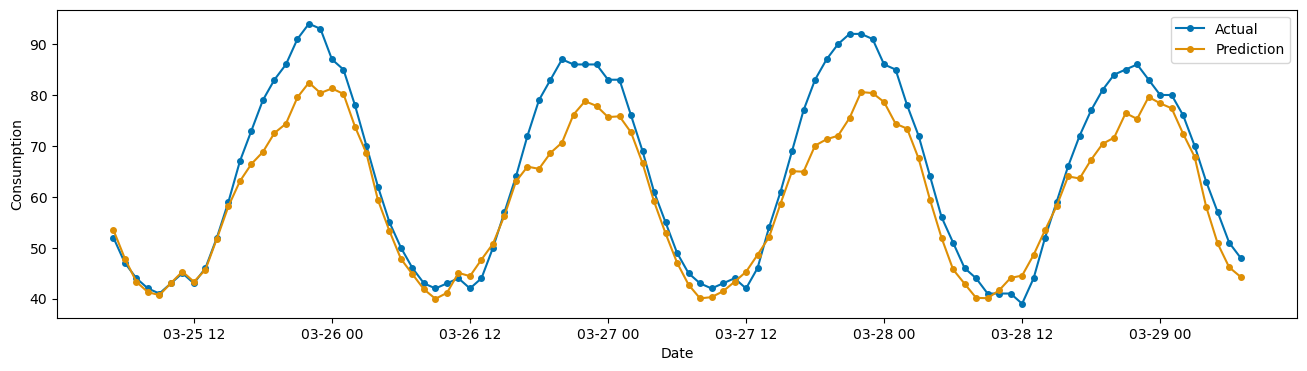

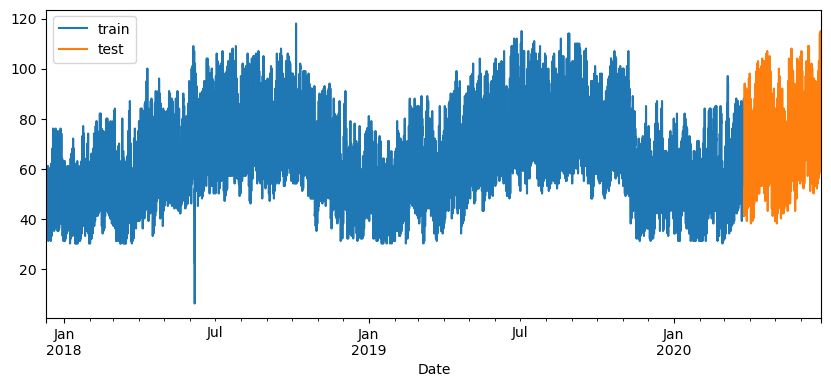

In [38]:
from sktime.forecasting.model_selection import temporal_train_test_split
train, test = temporal_train_test_split(y, train_size = 0.9)

fig, ax = plt.subplots(1,1, figsize=(10, 4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.legend()
plt.show()

In [7]:
from sktime.forecasting.arima import AutoARIMA
vlen = 100
fh=list(range(1, vlen,1))
arima_model = AutoARIMA(sp=12, suppress_warnings=True)

arima_model = AutoARIMA(
    sp=12,
    max_p=3, max_q=3, max_d=2,
    max_P=1, max_Q=1, max_D=1,
    suppress_warnings=True,
    stepwise=True,        # use stepwise search instead of full grid
    seasonal=True,        # ensure seasonal model
    n_jobs=-1             # use all cores
)
arima_model.fit(train)

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/skle

AutoARIMA(max_P=1, max_Q=1, max_p=3, max_q=3, n_jobs=-1, sp=12,
          suppress_warnings=True)

In [9]:

fh=list(range(1, vlen,1))
pred = arima_model.predict(fh)
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(test, pred, symmetric=False))

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [2221, 99]

In [11]:
from sktime.forecasting.base import ForecastingHorizon
# Suppose train and test are pandas Series with datetime index
h = len(test)  # forecast horizon length must match test set length
fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)
pred = arima_model.predict(fh)
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(test, pred, symmetric=False))

0.3120805283030165


/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
